In [1]:
%matplotlib inline
import seaborn
import quandl
import pandas as pd
import seaborn as sns
import math
from tsmom_model import *
import numpy as np
from datetime import datetime
import statsmodels.formula.api as sm
token="Us3wFmXGgAj_1cUtHAAR"

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

In [3]:
cleansed=load_amihud_markets_price()

tsmom_model.py:160: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('./Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
tsmom_model.py:162: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('./liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


In [4]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

tsmom_model.py:44: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('./Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
tsmom_model.py:46: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('./volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
tsmom_model.py:48: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,window=250,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:48: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:51: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future ve

# Presentation to be like "Time Varying Liquidity and Momentum Profits (2015) paper

Rank by deciles, HML (8,9,10) - (1,2,3).  Save monthly returns (equal (risk?) weighted) and if you want to annualized then resample.


Then correlation matrix 
* Overall market vol?
* Market illiquidity (median Amihud through time series)


# Amihud (2002) Annual portfolio sorts

In [5]:
data=calc_zscore_expanding_window(amihud.dropna(how='all'),3).dropna(how='all')
sector_zscores={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

tsmom_model.py:275: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=3,window=100000000,center=False).mean()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)
tsmom_model.py:275: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=3,window=100000000,center=False).std()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)


In [6]:
sector_rtns={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_rtns[sect]=np.log(cleansed[d_map[sect]].resample(rule='m',how='last')).diff().dropna(how='all')
sector_rtns['All']=np.log(cleansed.resample(rule='m',how='last')).diff().dropna(how='all')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  after removing the cwd from sys.path.
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """


In [7]:
sector_portfolio_sorts={}
for s in sector_zscores.keys():
    sector_portfolio_sorts[s]=quantile_portfolios_annual(sector_zscores[s],cleansed,2)
sector_portfolio_sorts['All']=quantile_portfolios_annual(data,cleansed,2)

tsmom_model.py:240: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).median()
  mkts=quantile_columns(rank_data.resample(rule='a',how='median'),year,number_of_buckets,i)
tsmom_model.py:241: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  rtns = price_data.resample(rule='m',how='last')[mkts].pct_change()[str(y+1)].mean(axis=1)


In [45]:
factors=pd.DataFrame()
for s in sector_portfolio_sorts.keys():
    factors[s]=sector_portfolio_sorts[s]['1']-sector_portfolio_sorts[s]['0']


In [46]:
factors.mean()

Agriculturals    0.000977
All              0.004763
Currencies       0.001681
Energies         0.005026
Equities         0.001277
Metals           0.000149
Fixed Income     0.001165
dtype: float64

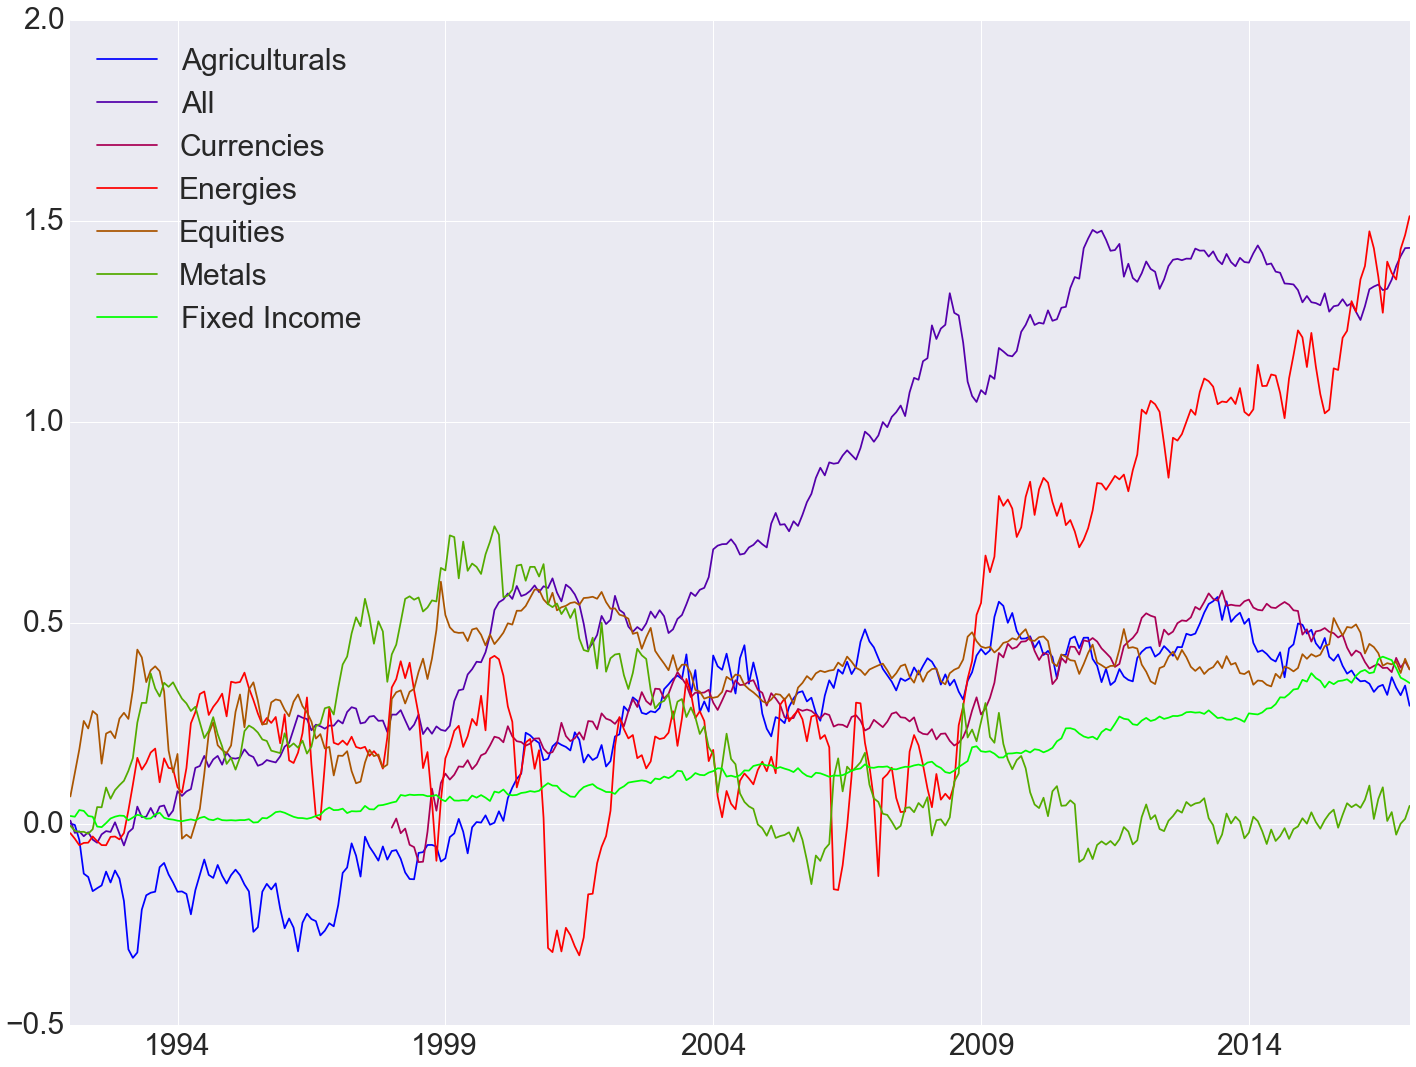

In [ ]:
factors.cumsum().plot(colormap='brg')

In [ ]:
final_res=pd.DataFrame()
betas_res=pd.DataFrame()
alpha={}
tstat={}
for sec in factors.columns:
    ind=factors.index
    reges=get_aqr_factors(sec).loc[ind]
    reges['Market Return']=sector_rtns[sec].mean(axis=1)
    reges['const']=1
    reges['TERM']=quandl.get('FRED/THREEFYTP10',authtoken=token).Value.resample(rule='m',how='last')
    res=sm.OLS(factors[sec],reges).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    if sec=='All':
        betas_res['AA']=res.params *100
        betas_res['AA_T']=res.tvalues
    alpha[sec]=res.params.const
    tstat[sec]=res.tvalues.const
final_res['alpha1']=pd.Series(alpha)*100
final_res['tstat']=pd.Series(tstat)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:10: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  # Remove the CWD from sys.path while we load stuff.


# FHT Annual portfolio sorts

In [ ]:
FHT=calculate_FHT(cleansed)
data=calc_zscore_expanding_window(FHT.dropna(how='all'),3).dropna(how='all')
sector_zscores={}
d_map=sector_map(FHT)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

In [ ]:
sector_portfolio_sorts={}
for s in sector_zscores.keys():
    sector_portfolio_sorts[s]=quantile_portfolios_annual(sector_zscores[s],cleansed,2)
sector_portfolio_sorts['All']=quantile_portfolios_annual(FHT,cleansed,2)

In [ ]:
factors_FHT=pd.DataFrame()
for s in sector_portfolio_sorts.keys():
    factors_FHT[s]=sector_portfolio_sorts[s]['1']-sector_portfolio_sorts[s]['0']


In [ ]:
factors_FHT['2000':].cumsum().plot()

In [ ]:
alpha={}
tstat={}
for sec in factors_FHT.columns:
    ind=factors_FHT['2000':'2016'].index
    reges=get_aqr_factors(sec).loc[ind]
    reges['Market Return']=sector_rtns[sec].mean(axis=1)
    reges['const']=1
    reges['TERM']=quandl.get('FRED/THREEFYTP10',authtoken=token).Value.resample(rule='m',how='last')
    res=sm.OLS(factors_FHT[sec]['2000':'2016'],reges).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    if sec=='All':
        betas_res['FA']=res.params  *100
        betas_res['FA_T']=res.tvalues
    alpha[sec]=res.params.const
    tstat[sec]=res.tvalues.const
final_res['alpha F-A']=pd.Series(alpha)*100
final_res['tstat2']=pd.Series(tstat)

In [17]:
final_res

,alpha1,tstat,alpha F-A,tstat2
Agriculturals,0.283120,1.093905,0.142735,0.666711
All,0.179068,1.467335,0.238169,2.331633
Currencies,0.082696,0.540227,0.095173,0.561922
Energies,0.586209,0.950328,0.449954,0.796730
Equities,-0.024803,-0.135790,-0.034496,-0.203013
Fixed Income,0.053297,0.830547,0.056234,1.385373
Metals,0.020079,0.074947,0.085985,0.297598


# Monthly portoflio sorts

In [18]:
amihud_monthly = read_monthly(amihud=True)

In [19]:
factors_monthly=pd.DataFrame()
for s in amihud_monthly.keys():
    factors_monthly[s]=amihud_monthly[s]['1']-amihud_monthly[s]['0']


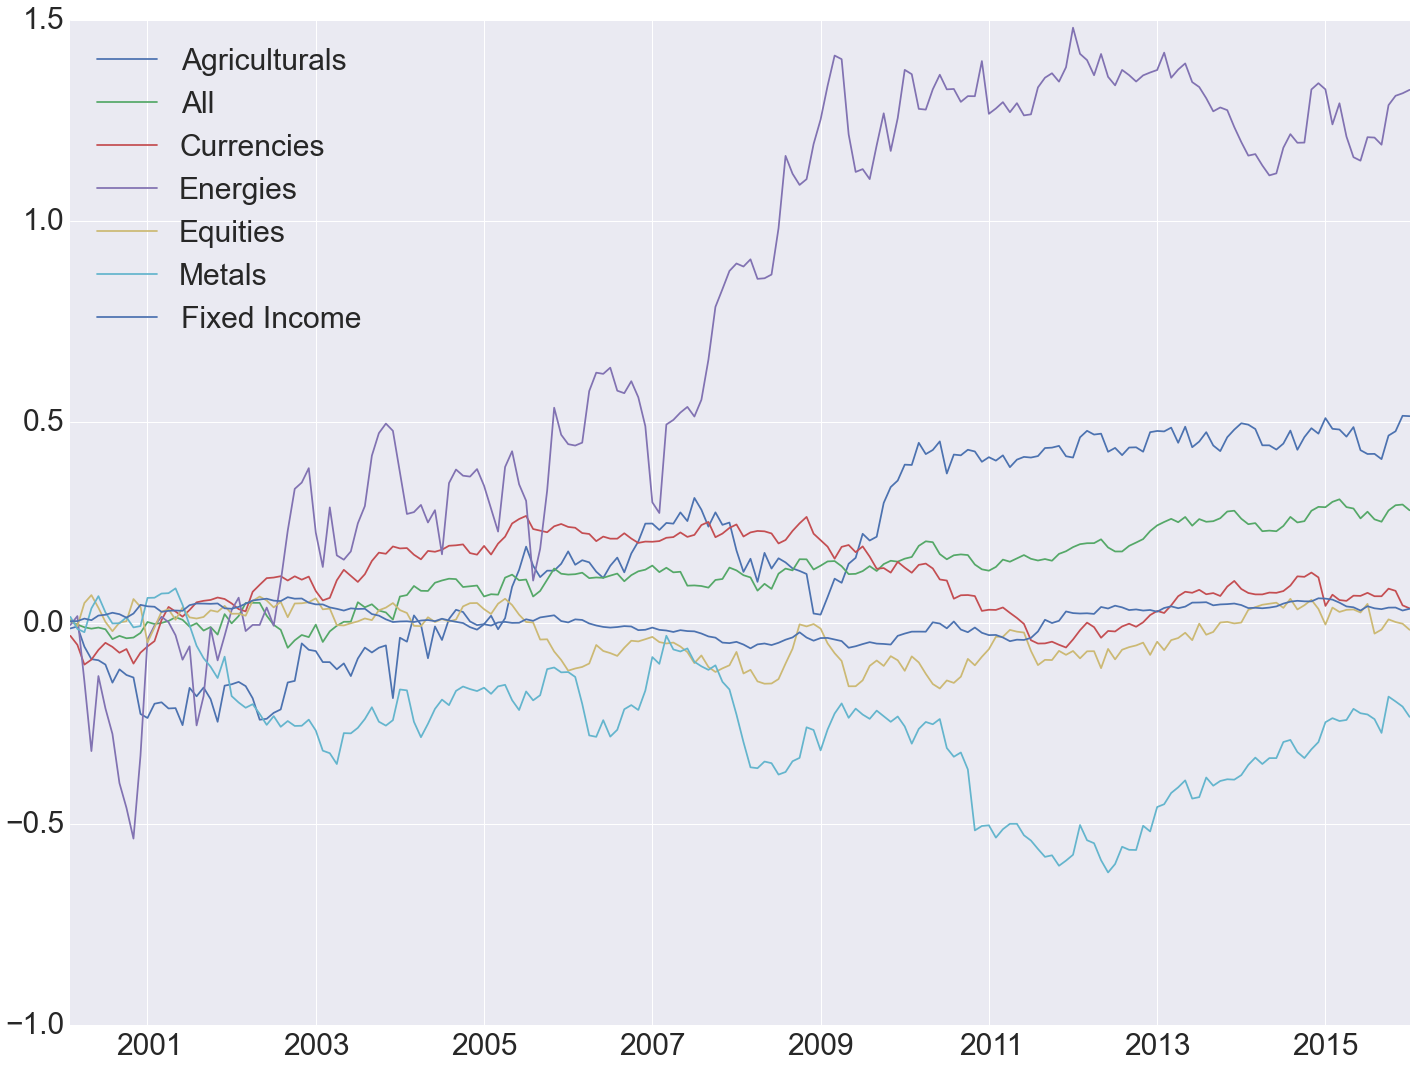

In [20]:
factors_monthly.cumsum().plot()

In [21]:
alpha={}
tstat={}
for sec in factors_monthly.columns:
    ind=factors_monthly['2000':'2016'].index
    reges=get_aqr_factors(sec).loc[ind]
    reges['Market Return']=sector_rtns[sec].mean(axis=1)
    reges['const']=1
    reges['TERM']=quandl.get('FRED/THREEFYTP10',authtoken=token).Value.resample(rule='m',how='last')
    res=sm.OLS(factors_monthly[sec].loc[ind],reges.loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    if sec=='All':
        betas_res['AM']=res.params  *100
        betas_res['AM_T']=res.tvalues
    alpha[sec]=res.params.const
    tstat[sec]=res.tvalues.const
final_res['alpha A-M']=pd.Series(alpha)*100
final_res['tstat3']=pd.Series(tstat)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  


In [22]:
final_res

,alpha1,tstat,alpha F-A,tstat2,alpha A-M,tstat3
Agriculturals,0.283120,1.093905,0.142735,0.666711,0.312568,1.240671
All,0.179068,1.467335,0.238169,2.331633,0.117758,0.914100
Currencies,0.082696,0.540227,0.095173,0.561922,-0.048400,-0.300232
Energies,0.586209,0.950328,0.449954,0.796730,0.841253,1.410177
Equities,-0.024803,-0.135790,-0.034496,-0.203013,-0.014488,-0.078363
Fixed Income,0.053297,0.830547,0.056234,1.385373,0.051150,0.697755
Metals,0.020079,0.074947,0.085985,0.297598,0.068890,0.231773


# Monthly FHT

In [23]:
FHT_monthly = read_monthly(amihud=False)

In [24]:
factors_monthly_FHT=pd.DataFrame()
for s in FHT_monthly.keys():
    factors_monthly_FHT[s]=FHT_monthly[s]['1']-FHT_monthly[s]['0']


In [25]:
alpha={}
tstat={}
for sec in factors_monthly_FHT.columns:
    ind=factors_monthly_FHT['2000':'2016'].index
    reges=get_aqr_factors(sec).loc[ind]
    reges['Market Return']=sector_rtns[sec].mean(axis=1)
    reges['const']=1
    reges['TERM']=quandl.get('FRED/THREEFYTP10',authtoken=token).Value.resample(rule='m',how='last')
    res=sm.OLS(factors_monthly_FHT[sec].loc[ind],reges).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    if sec=='All':
        betas_res['FM']=res.params  *100
        betas_res['FM_T']=res.tvalues
    alpha[sec]=res.params.const
    tstat[sec]=res.tvalues.const
final_res['alpha F-M']=pd.Series(alpha)*100
final_res['tstat4']=pd.Series(tstat)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  


In [26]:
final_res

,alpha1,tstat,alpha F-A,tstat2,alpha A-M,tstat3,alpha F-M,tstat4
Agriculturals,0.283120,1.093905,0.142735,0.666711,0.312568,1.240671,-0.296212,-1.020567
All,0.179068,1.467335,0.238169,2.331633,0.117758,0.914100,0.040309,0.301948
Currencies,0.082696,0.540227,0.095173,0.561922,-0.048400,-0.300232,0.066754,0.368768
Energies,0.586209,0.950328,0.449954,0.796730,0.841253,1.410177,0.983938,1.867833
Equities,-0.024803,-0.135790,-0.034496,-0.203013,-0.014488,-0.078363,0.335715,1.880161
Fixed Income,0.053297,0.830547,0.056234,1.385373,0.051150,0.697755,0.009275,0.165408
Metals,0.020079,0.074947,0.085985,0.297598,0.068890,0.231773,-0.006236,-0.022386


In [27]:
betas_res

,AA,AA_T,FA,FA_T,AM,AM_T,FM,FM_T
VAL,4.894491,0.658063,-10.365014,-1.789100,1.830187,0.245592,-13.548865,-1.372981
MOM,-2.697738,-0.353982,-11.161096,-1.616071,-5.344737,-0.681562,-13.004126,-1.843249
Market Return,2.261443,0.421718,93.144699,11.578119,1.079371,0.204228,13.309223,2.644994
const,0.179068,1.467335,0.238169,2.331633,0.117758,0.914100,0.040309,0.301948
TERM,-0.044613,-0.237651,0.150633,1.047804,0.081865,0.416365,-0.084204,-0.421363


# Alpha values 

$$r_{liquidity,t} = \alpha + \beta_1 r_{AssetClass,t} + \beta_2 MOM_{AssetClass,t} +
\beta_3 VAL_{AssetClass,t} + \varepsilon_t $$

In [28]:
print(final_res.T.round(2).to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &  Agriculturals &   All &  Currencies &  Energies &  Equities &  Fixed Income &  Metals \\
\midrule
alpha1    &           0.28 &  0.18 &        0.08 &      0.59 &     -0.02 &          0.05 &    0.02 \\
tstat     &           1.09 &  1.47 &        0.54 &      0.95 &     -0.14 &          0.83 &    0.07 \\
alpha F-A &           0.14 &  0.24 &        0.10 &      0.45 &     -0.03 &          0.06 &    0.09 \\
tstat2    &           0.67 &  2.33 &        0.56 &      0.80 &     -0.20 &          1.39 &    0.30 \\
alpha A-M &           0.31 &  0.12 &       -0.05 &      0.84 &     -0.01 &          0.05 &    0.07 \\
tstat3    &           1.24 &  0.91 &       -0.30 &      1.41 &     -0.08 &          0.70 &    0.23 \\
alpha F-M &          -0.30 &  0.04 &        0.07 &      0.98 &      0.34 &          0.01 &   -0.01 \\
tstat4    &          -1.02 &  0.30 &        0.37 &      1.87 &      1.88 &          0.17 &   -0.02 \\
\bottomrule
\end{tabular}



In [29]:
print final_res.T[[u'Agriculturals', u'Currencies', u'Energies', u'Equities',
       u'Fixed Income', u'Metals', u'All']].round(2).to_latex()


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Agriculturals &  Currencies &  Energies &  Equities &  Fixed Income &  Metals &   All \\
\midrule
alpha1    &           0.28 &        0.08 &      0.59 &     -0.02 &          0.05 &    0.02 &  0.18 \\
tstat     &           1.09 &        0.54 &      0.95 &     -0.14 &          0.83 &    0.07 &  1.47 \\
alpha F-A &           0.14 &        0.10 &      0.45 &     -0.03 &          0.06 &    0.09 &  0.24 \\
tstat2    &           0.67 &        0.56 &      0.80 &     -0.20 &          1.39 &    0.30 &  2.33 \\
alpha A-M &           0.31 &       -0.05 &      0.84 &     -0.01 &          0.05 &    0.07 &  0.12 \\
tstat3    &           1.24 &       -0.30 &      1.41 &     -0.08 &          0.70 &    0.23 &  0.91 \\
alpha F-M &          -0.30 &        0.07 &      0.98 &      0.34 &          0.01 &   -0.01 &  0.04 \\
tstat4    &          -1.02 &        0.37 &      1.87 &      1.88 &          0.17 &   -0.02 &  0.30 \\
\bottomrule
\end{tabular}



# These results are so bad from the beta's to the factors point of view from all markets.  It's just way to high for FHT

I am not going to present them in the results.

In [35]:
print(betas_res.T.round(2)[['const','Market Return','VAL','MOM','TERM']].to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  const &  Market Return &    VAL &    MOM &  TERM \\
\midrule
AA   &   0.18 &           2.26 &   4.89 &  -2.70 & -0.04 \\
AA\_T &   1.47 &           0.42 &   0.66 &  -0.35 & -0.24 \\
FA   &   0.24 &          93.14 & -10.37 & -11.16 &  0.15 \\
FA\_T &   2.33 &          11.58 &  -1.79 &  -1.62 &  1.05 \\
AM   &   0.12 &           1.08 &   1.83 &  -5.34 &  0.08 \\
AM\_T &   0.91 &           0.20 &   0.25 &  -0.68 &  0.42 \\
FM   &   0.04 &          13.31 & -13.55 & -13.00 & -0.08 \\
FM\_T &   0.30 &           2.64 &  -1.37 &  -1.84 & -0.42 \\
\bottomrule
\end{tabular}



# Adding additional factors

* TERM
* 

In [31]:
reges['TERM']=quandl.get('FRED/THREEFYTP10',authtoken=token).Value.resample(rule='m',how='last')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """Entry point for launching an IPython kernel.


In [34]:
betas_res

,AA,AA_T,FA,FA_T,AM,AM_T,FM,FM_T
VAL,4.894491,0.658063,-10.365014,-1.789100,1.830187,0.245592,-13.548865,-1.372981
MOM,-2.697738,-0.353982,-11.161096,-1.616071,-5.344737,-0.681562,-13.004126,-1.843249
Market Return,2.261443,0.421718,93.144699,11.578119,1.079371,0.204228,13.309223,2.644994
const,0.179068,1.467335,0.238169,2.331633,0.117758,0.914100,0.040309,0.301948
TERM,-0.044613,-0.237651,0.150633,1.047804,0.081865,0.416365,-0.084204,-0.421363


In [43]:
print res.summary()

                            OLS Regression Results                            
Dep. Variable:           Fixed Income   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     27.06
Date:                Fri, 17 Aug 2018   Prob (F-statistic):           6.18e-18
Time:                        16:28:13   Log-Likelihood:                 748.74
No. Observations:                 204   AIC:                            -1487.
Df Residuals:                     199   BIC:                            -1471.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
MOM_FI            0.0004      0.074      0.005

In [44]:
factors

,Agriculturals,All,Currencies,Energies,Equities,Metals,Fixed Income
2000-01-31,-0.055654,-0.010326,0.037552,-0.095232,0.012464,0.037483,-0.007752
2000-02-29,-0.003409,0.004095,0.031854,0.040961,0.029379,0.023852,-0.004405
2000-03-31,-0.008884,-0.007956,-0.001035,0.076088,-0.000987,-0.002141,-0.008619
2000-04-30,-0.003921,-0.006607,0.039218,0.126498,-0.034378,-0.009927,-0.003300
2000-05-31,-0.026950,-0.003539,0.001928,0.233571,-0.021745,0.019964,0.002273
2000-06-30,0.012682,0.002758,-0.049402,-0.119707,0.004284,0.048209,-0.000891
2000-07-31,-0.041162,-0.004238,0.048687,-0.031752,-0.028980,0.039559,-0.004844
2000-08-31,-0.045389,-0.024569,0.048859,0.008819,0.017555,-0.021808,-0.006436
2000-09-30,0.020757,0.008081,-0.011024,0.131204,0.011628,0.000492,0.000992
2000-10-31,-0.015319,-0.005942,0.037181,-0.001263,-0.042395,0.041517,-0.006692
